In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedashrafhassan","key":"601588b63dba7ad1d80be2b29c1c9058"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 79% 95.0M/121M [00:00<00:00, 243MB/s]
100% 121M/121M [00:00<00:00, 240MB/s] 


In [ ]:
!unzip /content/face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
!pip install mtcnn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.0 MB/s eta 0:00:00


# Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import urllib.request
import mtcnn
from mtcnn.mtcnn import MTCNN
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# Load Dataset

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [ ]:
def preprocess(image):
      img= np.asarray(bytearray(image.read()), dtype="uint8")
      img = cv2.imdecode(img, cv2.IMREAD_COLOR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #img=  cv2.resize(img,(48,48))
      unsharp_image = cv2.GaussianBlur(img, (0,0), 3)
      unsharp_image = cv2.addWeighted(img, 1.5, unsharp_image, -0.5, 0)
      return unsharp_image

def detect_face(image):
      detector = MTCNN()
      bounding_boxes = detector.detect_faces(image)
      return bounding_boxes


def draw_bounding_boxes(image, bboxes):
      for box in bboxes:
          x1, y1, w, h = box['box']
          cv2.rectangle(image, (x1, y1), (x1+w,y1+h), (0,255,0), 2)


def mark_key_point(mage, keypoint):
      cv2.circle(image, (keypoint), 1, (0,255,0), 2)


def crop_image(image):
      for bbox in bboxes:
          L = bbox['box']
          x, y, w, h = L[0],L[1],L[2],L[3]
          cropped_image = image[y:y+h, x:x+w]
          # Do something with the cropped image
          #plt.imshow(cropped_image)
          return cropped_image

In [ ]:
def CNN(input_shape,output_class):
    
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.4))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.3))

    model.add(Dense(output_class, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Feature Extraction

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

# Preprocessing Data

In [ ]:
TRAIN_DIR = "/content/images/train/"
TEST_DIR = "/content/images/validation/"

## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

happy Completed
angry Completed
surprise Completed
fear Completed
sad Completed
disgust Completed
neutral Completed


,image,label
0,/content/images/train/sad/34357.jpg,sad
1,/content/images/train/happy/13459.jpg,happy
2,/content/images/train/sad/10049.jpg,sad
3,/content/images/train/neutral/6499.jpg,neutral
4,/content/images/train/neutral/29754.jpg,neutral


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

happy Completed
angry Completed
surprise Completed
fear Completed
sad Completed
disgust Completed
neutral Completed


,image,label
0,/content/images/validation/happy/17022.jpg,happy
1,/content/images/validation/happy/20285.jpg,happy
2,/content/images/validation/happy/25287.jpg,happy
3,/content/images/validation/happy/34119.jpg,happy
4,/content/images/validation/happy/30835.jpg,happy


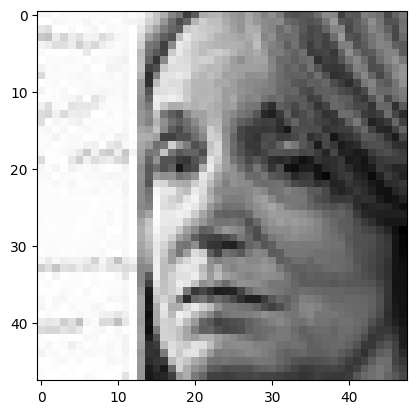

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

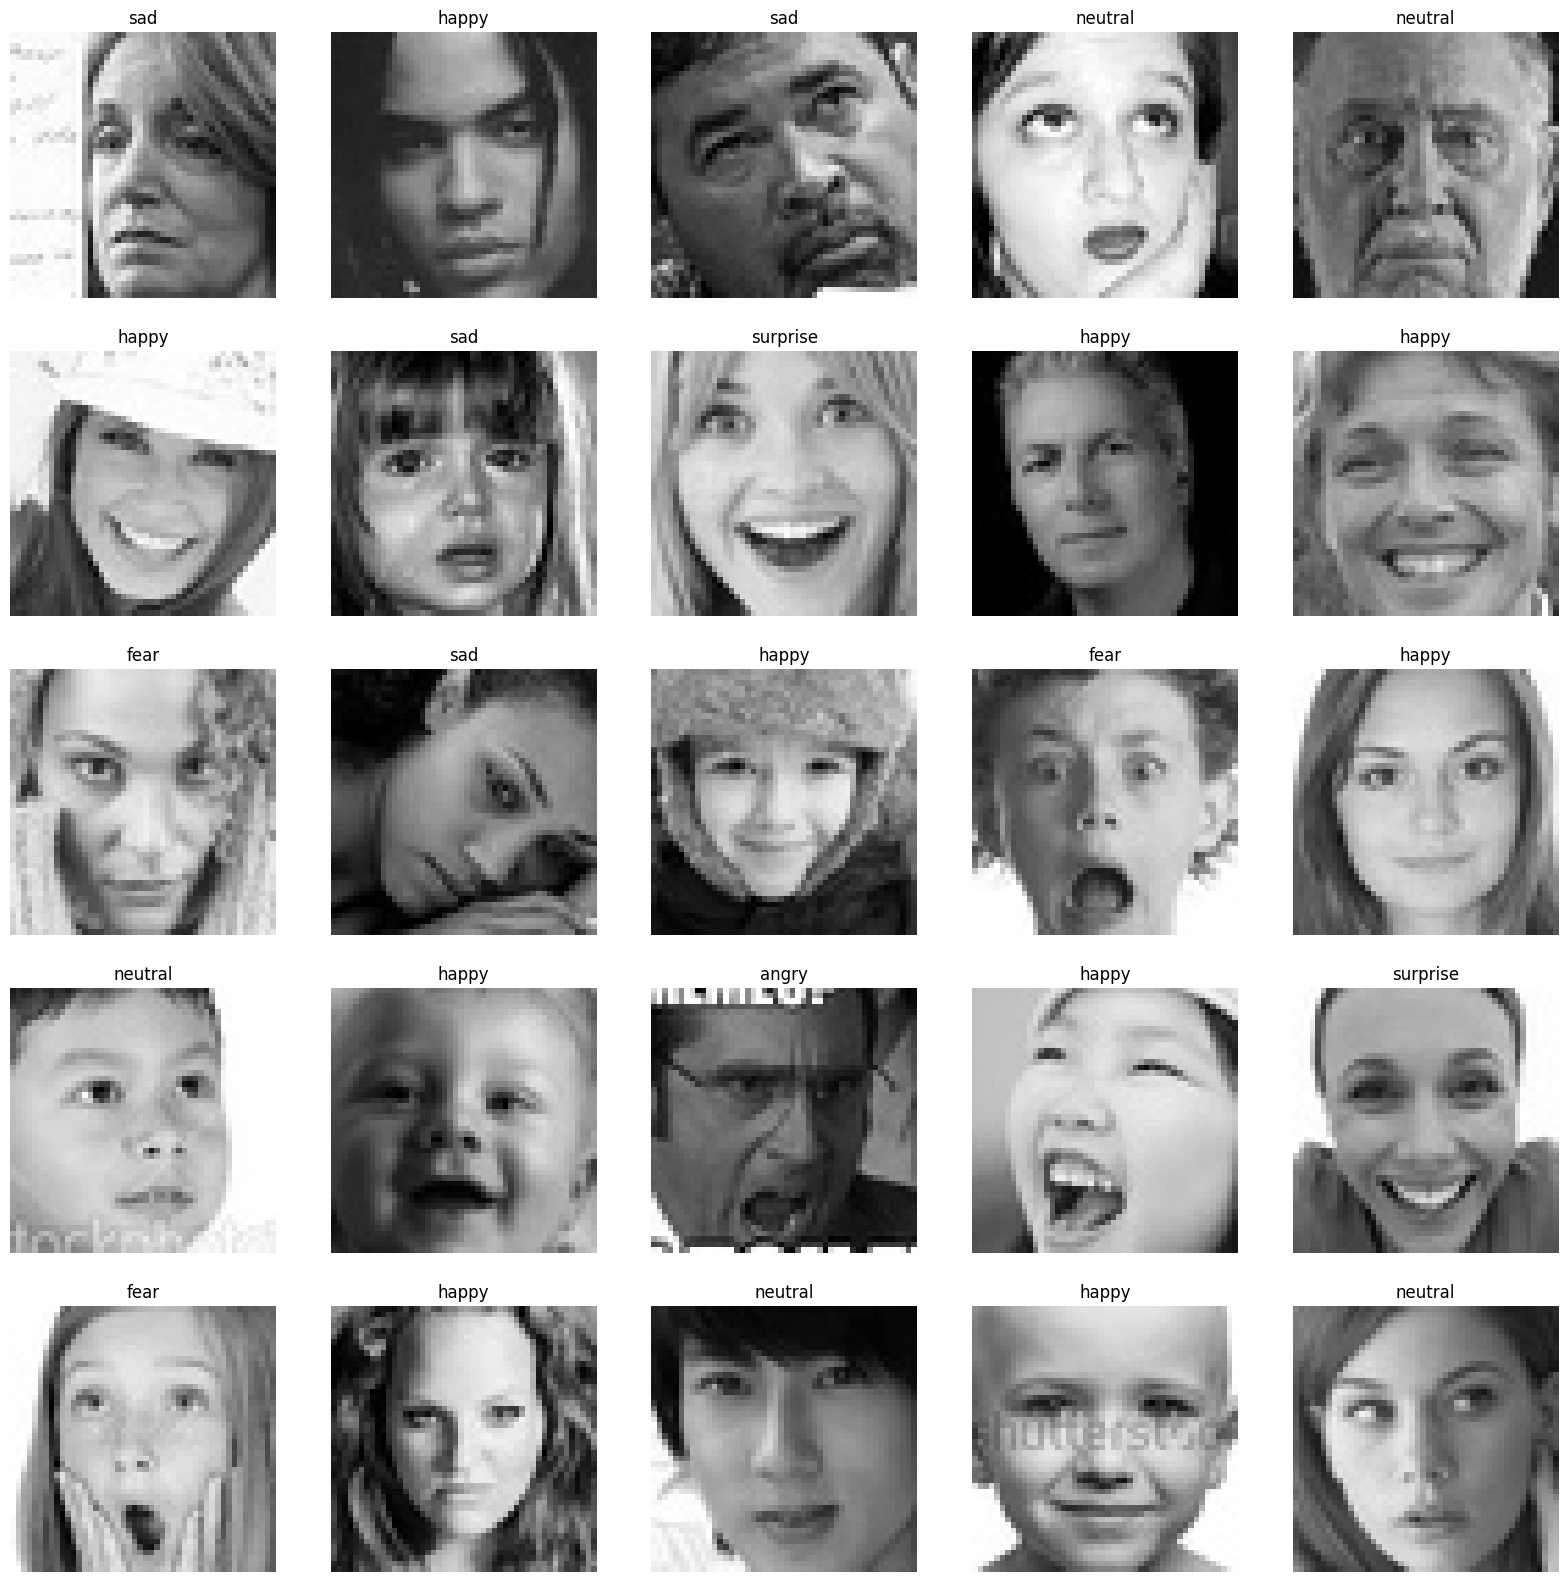

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

# Extract and Normalize

In [ ]:
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

  0%|          | 0/28821 [00:00<?, ?it/s]

  0%|          | 0/7066 [00:00<?, ?it/s]

In [ ]:
## convert label to integer

le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# Train

In [ ]:

input_shape = (48, 48, 1)
output_class = 7

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model=CNN(input_shape,output_class)
history = model.fit(x=x_train, y=y_train, batch_size=200, epochs=50, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Epoch 1/50
145/145 [==============================] - 40s 125ms/step - loss: 1.8847 - accuracy: 0.2611 - val_loss: 1.9891 - val_accuracy: 0.1441 - lr: 0.0010
Epoch 2/50
145/145 [==============================] - 17s 118ms/step - loss: 1.5507 - accuracy: 0.3981 - val_loss: 2.7601 - val_accuracy: 0.2583 - lr: 0.0010
Epoch 3/50
145/145 [==============================] - 17s 118ms/step - loss: 1.3779 - accuracy: 0.4690 - val_loss: 1.8235 - val_accuracy: 0.2802 - lr: 0.0010
Epoch 4/50
145/145 [==============================] - 18s 123ms/step - loss: 1.2574 - accuracy: 0.5167 - val_loss: 1.4887 - val_accuracy: 0.4379 - lr: 0.0010
Epoch 5/50
145/145 [==============================] - 18s 124ms/step - loss: 1.1796 - accuracy: 0.5488 - val_loss: 1.3427 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 6/50
145/145 [==============================] - 17s 119ms/step - loss: 1.1168 - accuracy: 0.5729 - val_loss: 1.4767 - val_accuracy: 0.4772 - lr: 0.0010
Epoch 7/50
145/145 [==============================] 

In [ ]:
# Evaluate model on test dataset
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.902600646018982
Test accuracy: 0.6081234216690063


In [ ]:
model.save('model_CNN.h5')


In [ ]:
model = keras.models.load_model('/content/model_CNN.h5')

In [ ]:
image_path = "https://ychef.files.bbci.co.uk/976x549/p066st0k.jpg"

image = urllib.request.urlopen(image_path)

1/1 [==============================] - 0s 122ms/step
Output of MTCNN detector is...
 [{'box': [392, 99, 196, 269], 'confidence': 0.9999932050704956, 'keypoints': {'left_eye': (443, 190), 'right_eye': (538, 188), 'nose': (487, 218), 'mouth_left': (459, 299), 'mouth_right': (517, 299)}}]


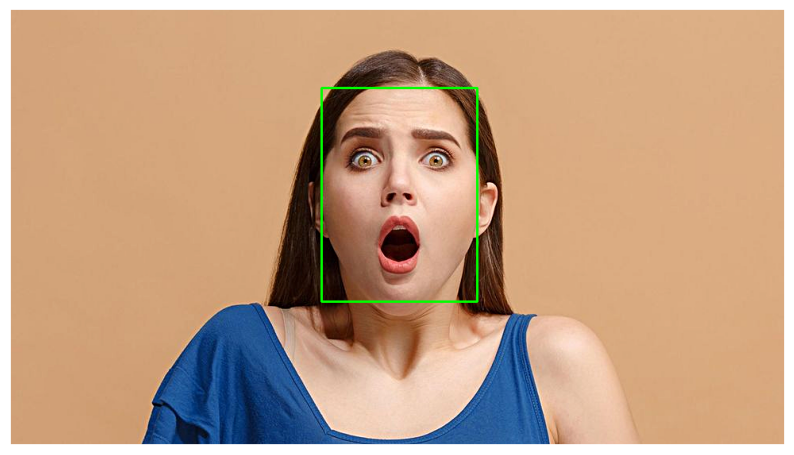

In [ ]:

image = urllib.request.urlopen(image_path)
image=preprocess(image)
bboxes=detect_face(image)
print("Output of MTCNN detector is...\n",bboxes)
draw_bounding_boxes(image,bboxes)
result=crop_image(image).copy()

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

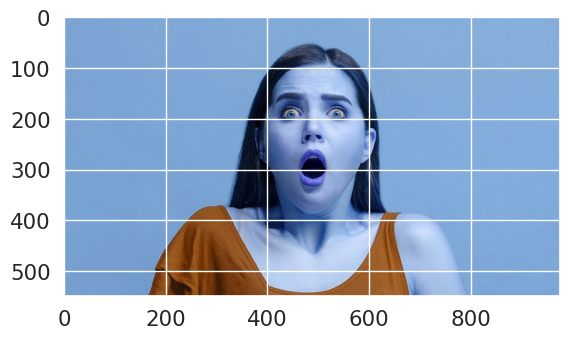

In [ ]:
image = cv2.imread('/content/p066st0k.jpg')
plt.imshow(image)


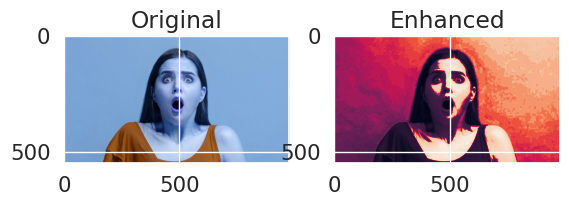

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.filters
import cv2

# Load image and convert to grayscale
gray_image = cv2.imread('/content/p066st0k.jpg', cv2.IMREAD_GRAYSCALE)


# Apply histogram equalization
gray_image_array = np.array(gray_image)
enhanced_image_array = cv2.equalizeHist(gray_image_array)

# Convert back to PIL image and save
enhanced_image = Image.fromarray(enhanced_image_array)
enhanced_image.save('enhanced_image.jpg')

# Display original and enhanced images
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title('Enhanced')
plt.imshow(enhanced_image)
plt.show()


1/1 [==============================] - 0s 26ms/step
Predicted Output: fear


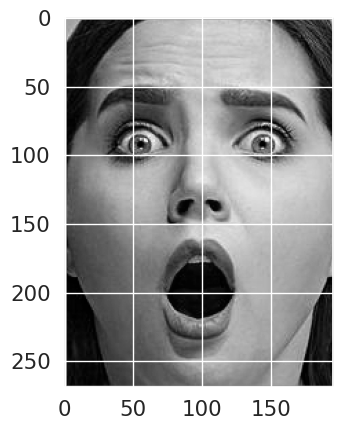

In [ ]:
result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
img=result.copy()
result = cv2.resize(result, (48, 48))
pred = model.predict(result.reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax(axis=-1)])[0]
print("Predicted Output:", prediction_label)
plt.imshow(img, cmap='gray');

Original Output: neutral
1/1 [==============================] - 0s 20ms/step
Predicted Output: sad


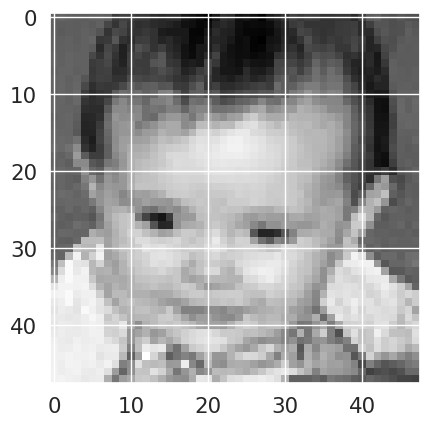

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax(axis=-1)])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

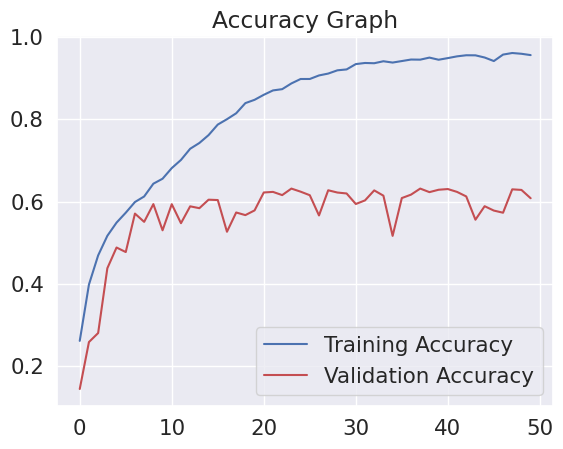

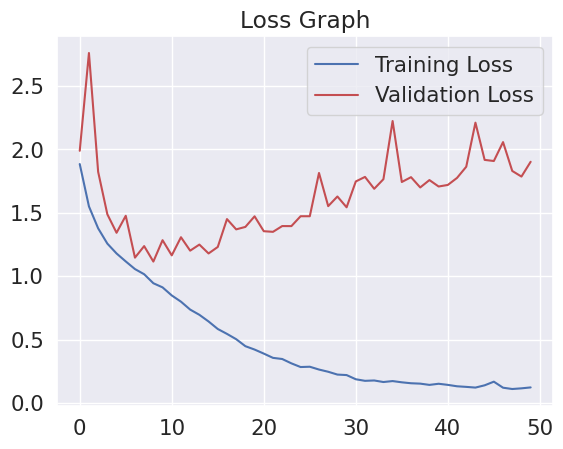

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

221/221 [==============================] - 1s 5ms/step


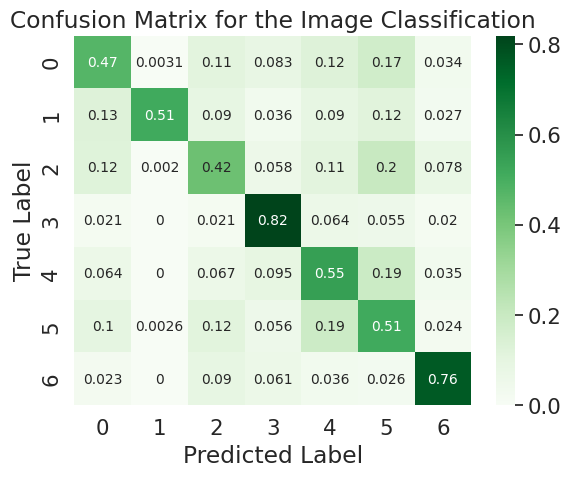

In [ ]:
# Use the model to make predictions on the test set
y_pred = np.argmax(model.predict(x_test), axis=1)

# Convert one-hot encoded labels to categorical labels
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
norm_conf_mat = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

# Get the class labels
classes = unique_labels(y_true, y_pred)

# Create a data frame from the normalized confusion matrix
conf_mat_df = pd.DataFrame(norm_conf_mat, index=classes, columns=classes)

# Create a heatmap of the normalized confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_df, annot=True, annot_kws={"size": 10}, cmap="Greens")

# Add labels to the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for the Image Classification')

# Show the plot
plt.show()